In [1]:
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf

import numpy as np


/home/agus/anaconda3/envs/basic/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def convert_conlltxt2dataset(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    
    del lines[0]
    del lines[0]
    
    dataset = []
    sentence = []
    for line in lines:
        splitter = line.strip().split(' ')
        if splitter[0] == '':
            continue
        elif (splitter[0] == '-DOCSTART-'):
            dataset.append(sentence)
            sentence = []
        else:
            token = splitter[0]
            tag = splitter[3]
            sentence.append((token, tag))
    return dataset

In [3]:
train_dataset = convert_conlltxt2dataset('datasets/conll2003/train.txt')
test_dataset = convert_conlltxt2dataset('datasets/conll2003/test.txt')

In [4]:
def df2token(prepared_df):
    token_list = []
    for sent in prepared_df:
        for token, tag in sent:
            token_list.append(token)
    return token_list

def df2tag(prepared_df):
    tag_list = []
    for sent in prepared_df:
        for token, tag in sent:
            tag_list.append(tag)
    return tag_list

token = df2token(train_dataset)
tag = df2tag(train_dataset)

token_test = df2token(test_dataset)
tag_test = df2tag(test_dataset)

In [5]:
tokens = list(set(token))
n_tokens = len(tokens); n_tokens

23623

In [6]:
tags = list(set(tag))
n_tags = len(tags); n_tags

9

In [7]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(tokens)}
tag2idx = {t: i for i, t in enumerate(tags)}
print(tag2idx)

{'B-PER': 0, 'B-MISC': 1, 'I-PER': 2, 'I-MISC': 3, 'O': 4, 'B-LOC': 5, 'B-ORG': 6, 'I-LOC': 7, 'I-ORG': 8}


In [8]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in train_dataset]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)
y = [[tag2idx[w[1]] for w in s] for s in train_dataset]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

X_test = [[word2idx[w[0]] if w[0] in word2idx else 0 for w in s] for s in test_dataset]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=0)
y_test = [[tag2idx[w[1]] for w in s] for s in test_dataset]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

Using TensorFlow backend.


In [9]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

In [10]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = X, X_test, y, y_test

In [11]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [12]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_tokens + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output


In [13]:
model = Model(input, out)

In [14]:
from keras import optimizers

optimizer_ = optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer_, loss=crf.loss_function, metrics=[crf.accuracy])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            472480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 9)             558       
Total params: 506,488
Trainable params: 506,488
Non-trainable params: 0
_________________________________________________________________


In [16]:
%%time
history = model.fit(np.array(X_tr), np.array(y_tr), batch_size=32, epochs=6,
                    validation_split=0.1, verbose=1)

Train on 850 samples, validate on 95 samples
Epoch 1/6
850/850 [==============================] - 8s 10ms/step - loss: 2.0304 - acc: 0.7044 - val_loss: 0.6122 - val_acc: 0.8781
Epoch 2/6
850/850 [==============================] - 6s 7ms/step - loss: 0.7933 - acc: 0.8286 - val_loss: 0.5820 - val_acc: 0.8797
Epoch 3/6
850/850 [==============================] - 6s 7ms/step - loss: 1.3242 - acc: 0.7783 - val_loss: 0.5228 - val_acc: 0.8782
Epoch 4/6
850/850 [==============================] - 6s 7ms/step - loss: 0.6263 - acc: 0.8245 - val_loss: 0.4600 - val_acc: 0.8271
Epoch 5/6
850/850 [==============================] - 6s 7ms/step - loss: 0.5516 - acc: 0.8410 - val_loss: 0.3889 - val_acc: 0.8878
Epoch 6/6
850/850 [==============================] - 6s 7ms/step - loss: 0.4470 - acc: 0.8780 - val_loss: 0.3494 - val_acc: 0.9041
CPU times: user 1min 37s, sys: 11.1 s, total: 1min 48s
Wall time: 41.9 s


In [17]:
hist = pd.DataFrame(history.history)

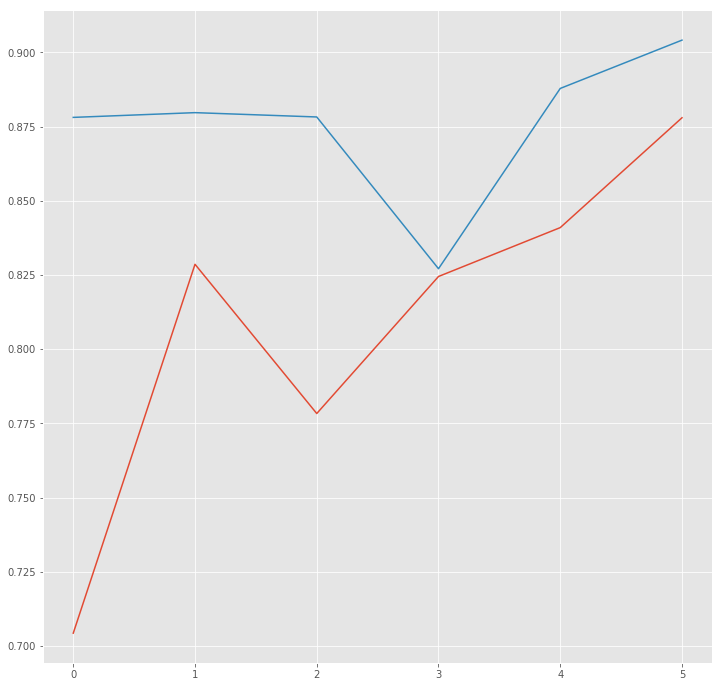

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [19]:
%%time
prediction = model.predict(X_te)

CPU times: user 1.99 s, sys: 350 ms, total: 2.34 s
Wall time: 807 ms


In [20]:
prediction[0]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0.

In [21]:
def confusion_deep_learning(tag_number, label, prediction):
    '''
    Confusion metrics that can be used in the Bi-LSTM CRF 
    '''
    TP = 0
    TN = 0
    FN = 0
    FP = 0 
    for i, y in enumerate(label):
        for j, tag in enumerate(y):
            if tag[tag_number] == prediction[i][j][tag_number] and tag[tag_number] == 1.0:
                TP += 1
            elif tag[tag_number] == prediction[i][j][tag_number] and tag[tag_number] == 0.0:
                TN += 1
            elif tag[tag_number] != prediction[i][j][tag_number] and tag[tag_number] == 1.0:
                FN += 1
            else:
                FP += 1
    print('True Positive:', TP)
    print('True Negative:', TN)
    print('False Positive:', FP)
    print('False Negative:', FN)

    if TP + FP == 0:
        precission = 0
    else:
        precission = TP / (TP+FP)
    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP+FN)
    if (2 * TP + FP + FN) == 0:
        f1 = 0
    else:
        f1 = (2 * TP) / (2 * TP + FP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    print('Precission:', precission)
    print('Recall:', recall)
    print('F1 Score:', f1)
    print('Accuracy:', accuracy)
    return f1

In [22]:
import numpy as np
scores = []
for i in range(8):
    print(i + 1)
    scores.append(confusion_deep_learning(i+1, y_te, prediction))
print(scores)
print(np.mean(np.array(scores)))

1
True Positive: 7
True Negative: 17032
False Positive: 2
False Negative: 209
Precission: 0.7777777777777778
Recall: 0.032407407407407406
F1 Score: 0.06222222222222222
Accuracy: 0.987768115942029
2
True Positive: 93
True Negative: 16664
False Positive: 110
False Negative: 383
Precission: 0.458128078817734
Recall: 0.1953781512605042
F1 Score: 0.27393225331369664
Accuracy: 0.9714202898550724
3
True Positive: 0
True Negative: 17165
False Positive: 0
False Negative: 85
Precission: 0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.995072463768116
4
True Positive: 11833
True Negative: 2298
False Positive: 759
False Negative: 2360
Precission: 0.9397236340533672
Recall: 0.8337208483055027
F1 Score: 0.8835542281127496
Accuracy: 0.8191884057971015
5
True Positive: 242
True Negative: 16484
False Positive: 161
False Negative: 363
Precission: 0.6004962779156328
Recall: 0.4
F1 Score: 0.4801587301587302
Accuracy: 0.9696231884057971
6
True Positive: 118
True Negative: 16426
False Positive: 188
False Negative: 5